In [ ]:
import pandas as pd
import numpy as np
import json

import tensorflow as tf

from sklearn.model_selection import train_test_split

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Projects/Football Team Simulation/data"
# SAVE_DIR = DATA_DIR + "/raw/Premier-League/2022-2023_Matches"
# TABLE_REF_PATH = DATA_DIR + "/raw/Premier-League/table_ref.csv"
TRANSFORM_DIR = DATA_DIR + "/transformed"
MODEL_DIR = "/content/drive/MyDrive/Projects/Football Team Simulation/models/"

## Data Acquisition

In [ ]:
dataset = pd.read_parquet(f"{TRANSFORM_DIR}/preprocessed_data_for_ml.parquet")

dataset_np = pd.read_parquet(f"{TRANSFORM_DIR}/data_for_ml.parquet")

In [ ]:
# dataset.info()

In [ ]:
# dataset.head()

In [ ]:
# X, y = dataset.iloc[:, :-5], dataset.iloc[:, -5:]
X, y = dataset_np.iloc[:, :-5], dataset_np.iloc[:, -5:]

In [ ]:
# X.loc[:, pd.IndexSlice["Home", "Player_01"]].drop(["Pos"], axis=1)
# X_non_pos = X.drop(["Pos"], axis=1, level=2)
# X_pos = X.loc[:, pd.IndexSlice[:, :, "Pos"]]

In [ ]:
dataset_np.loc[:, pd.IndexSlice["Home", "Player_03"]].head()

<ipython-input-9-64359b097011>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  dataset_np.loc[:, pd.IndexSlice["Home", "Player_03"]].head()


Statistic,keeper - Performance - Save%,keeper - Performance - CS%,keeper_adv - Expected - PSxG/SoT,keeper_adv - Expected - /90,shooting - Standard - SoT%,shooting - Standard - SoT/90,shooting - Standard - G/SoT,shooting - Expected - G-xG,passing - xAG,passing - xA,...,gca - SCA - SCA90,gca - GCA - GCA90,defense - Tkl+Int,defense - Clr,defense - Blocks - Blocks,playing_time - Team Success - PPM,playing_time - Team Success (xG) - On-Off,misc - Performance - Recov,misc - Aerial Duels - Won%,Pos
0,0.0,0.0,0.0,0.0,33.3,0.65,0.45,0.4,3.9,2.6,...,4.29,0.82,31.0,13.0,18.0,2.61,-0.49,64.0,20.8,RW
1,0.0,0.0,0.0,0.0,16.7,0.20,1.00,1.3,1.3,1.5,...,3.73,0.30,35.0,12.0,16.0,0.78,-0.25,47.0,28.6,RW
2,0.0,0.0,0.0,0.0,30.4,0.76,0.64,3.6,1.5,1.9,...,3.26,0.49,42.0,8.0,21.0,1.95,-0.47,91.0,33.3,RW
3,0.0,0.0,0.0,0.0,44.6,1.32,0.40,1.8,2.3,2.0,...,2.69,0.42,20.0,5.0,23.0,2.00,0.03,58.0,34.8,"RW,FW"
4,0.0,0.0,0.0,0.0,23.3,0.48,0.30,-2.2,3.1,2.5,...,2.92,0.29,44.0,13.0,25.0,0.90,-8.80,82.0,29.1,AM


## Football Transformer

In [ ]:
REGISTER_FEATURES = [
    # pre-match player information/stats
    'keeper - Performance - Save%',
    'keeper - Performance - CS%',
    'keeper_adv - Expected - PSxG/SoT',
    'keeper_adv - Expected - /90',
    'shooting - Standard - SoT%',
    'shooting - Standard - SoT/90',
    'shooting - Standard - G/SoT',
    'shooting - Expected - G-xG',
    'passing - xAG',
    'passing - xA',
    'passing - KP',
    'gca - SCA - SCA90',
    'gca - GCA - GCA90',
    'defense - Tkl+Int',
    'defense - Clr',
    'defense - Blocks - Blocks',
    'playing_time - Team Success - PPM',
    'playing_time - Team Success (xG) - On-Off',
    'misc - Performance - Recov',
    'misc - Aerial Duels - Won%',
    # post-match player information/stats
    # "Pos",
]

POSITION_CHOICES = [
    "GK", 
    "DF", "CB", "FB", "LB", "RB", "WB",
    "MF", "DM", "CM", "LM", "RM", "WM", "AM",
    "FW", "LW", "RW"
]

ATTRIBUTE_DIMENSION = X.loc[:, pd.IndexSlice["Home", "Player_01", :]].shape[1]

In [ ]:
print(len(REGISTER_FEATURES))
print(ATTRIBUTE_DIMENSION)

20
21


### Embedding

References:
- https://datascience.stackexchange.com/questions/93931/bert-embedding-layer
- https://ai.stackexchange.com/questions/37021/which-positional-encoding-bert-use
- https://stats.stackexchange.com/questions/324992/how-the-embedding-layer-is-trained-in-keras-embedding-layer

#### Embedding Training Ideas

#### Position Compatibility
1. In 1 team, given 11 positions (forget player attributes), mask 1-2 positions and then make the model try to predict it. Maybe can also be train simultaneously with the original task.

2. Try to assume only one position for one player in one match. Then try [tabular transformer](https://towardsdatascience.com/transformers-for-tabular-data-tabtransformer-deep-dive-5fb2438da820) by separating the processing of attributes and positions. The 11 positions in each team will go through Categorical Embedding, then Transformer Encoder, from which the Contextual Embedding will be produced and then concatenate it with attributes. (Be careful with the ordering. Maybe it matters for the model? Even though it shouldn't)

3. The model is trained simultaneously alongside the main task which is predicting score.


#### Player-Position Compatibility
1. Train a player-position compatibility model that given set of attributes of a player and his position, determine whether it's a fit (1) or not (0).

2. Positive-labeled samples are clear as day. As for negative labels, just swap the position/set of attributes. For example Mohamed Salah's attributes + GK as inputs have 0 as label.

3. The output of the player-position model is between 0-1 (sigmoid activation function). Player-position model then used for the bigger model as feature extraction. Concatenated with Position Compatibility model and raw attribute values.

4. Or just hand-pick some of the (statistically or by common knowledge) best players on their respective positions, and then compare each of the attribute values. If one attribute equals or surpasses the benchmark player then assign multiply the original value by one. If it's lesser then get the ratio difference between them and then multiply it to the original value. Basically the following formula to represent how well a player represent their position:

 $ newValue = \min(\frac{originalValue}{benchmarkValue}, 1) $

5. How each position affect each attribute, how to model it, and how to train it still need some thinkering. Maybe can be modeled by first try to cluster which attributes are important for each positions. And then rank the attributes based on their cluster. These rank will give additional values to each attribute (can be by dot product of feature vector and feature rank)

#### FT Embedding

In [ ]:
def FT_Embedding(attribute_dimension):
    player_inputs = []
    player_position_inputs = []
    player_embeddings = []

    for _ in range(22):
        player_input = tf.keras.Input(shape=(attribute_dimension,))
        player_pos_input = tf.keras.Input(shape=(1,))

        player_inputs.append(player_input)
        player_position_inputs.append(player_pos_input)
    
    pos_emb = tf.keras.layers.Embedding(
        input_dim=17,
        output_dim=attribute_dimension
    )

    for i in range(22):
        encoded_pos = pos_emb(player_position_inputs[i])
        player_embedding = tf.keras.layers.Add()([player_inputs[i], encoded_pos])
        player_embeddings.append(player_embedding)
    
    ft_embedding = tf.keras.layers.Concatenate([player_embeddings])
    return player_inputs, player_position_inputs, ft_embedding

In [ ]:
class FTE(tf.keras.layers.Layer):
    def __init__(self, attribute_dim):
        super(FTE, self).__init__(name='FTE')
        self.player_inputs = []
        self.player_position_inputs = []
        for idx in range(22):
            self.player_inputs.append(tf.keras.Input(shape=(attribute_dim,), name=f'player-{idx+1}-input'))
            self.player_position_inputs.append(tf.keras.Input(shape=(1,), name=f'player-{idx+1}-pos-input'))
        self.embedding = tf.keras.layers.Embedding(input_dim=17, output_dim=attribute_dim)
        self.add = tf.keras.layers.Add()
    
    def call(self, player_inputs, player_position_inputs):
        ft_embeds = []
        for idx in range(22):
            encoded_pos = self.embedding(self.player_position_inputs[idx])
            player_embedding = self.add([player_inputs[idx], encoded_pos])
            ft_embeds.append(player_embedding)
        
        return tf.keras.layers.Concatenate(ft_embeds)

In [ ]:
class FT_Embedding(tf.keras.layers.Layer):
    def __init__(self, attribute_dimension):
        super(FT_Embedding, self).__init__(name="FT-Embedding")
        self.attribute_dimension = attribute_dimension

        self.home_team_embedding = team_embedding(attribute_dimension, name="home-team-embedding")
        self.home_opposition_embedding = opposition_embedding(attribute_dimension, name="home-opposition-embedding")

        self.away_team_embedding = team_embedding(attribute_dimension, name="away-team-embedding")
        self.away_opposition_embedding = opposition_embedding(attribute_dimension, name="away-opposition-embedding")

    def call(self, ft_preprocessed_inputs):
        home, home_stats_average, away, away_stats_average = ft_preprocessed_inputs
        
        # # get the numpy of the tensor
        # home = home.numpy()
        # away = away.numpy()

        # # temporarily store the column names
        # home_columns = home.columns
        # away_columns = away.columns

        # # change pandas dataframe to numpy array
        # home = np.array(home)
        # away = np.array(away)

        # process each player values from each team
        for i in range(11):
            
            home_player_stats = home[:, self.attribute_dimension*i:self.attribute_dimension*(i+1)]
            home_team_embedding_inputs = tf.concat([home_player_stats, home_stats_average], axis=1)
            home_opposition_embedding_inputs = tf.concat([home_player_stats, away_stats_average], axis=1)
            # print(home_team_embedding_inputs) # shape: attribute_dim + attribute_dim

            home_team_stats = self.home_team_embedding(home_team_embedding_inputs)
            home_opposition_stats = self.home_opposition_embedding(home_opposition_embedding_inputs)
            home[:, self.attribute_dimension*i:self.attribute_dimension*(i+1)] = home_player_stats + home_team_stats + home_opposition_stats

            away_player_stats = away[:, self.attribute_dimension*i:self.attribute_dimension*(i+1)]
            away_team_embedding_inputs = tf.concat([away_player_stats, away_stats_average], axis=1)
            away_opposition_embedding_inputs = tf.concat([away_player_stats, home_stats_average], axis=1)

            away_team_stats = self.away_team_embedding(away_team_embedding_inputs)
            away_opposition_stats = self.away_opposition_embedding(away_opposition_embedding_inputs)
            away[:, self.attribute_dimension*i:self.attribute_dimension*(i+1)] = away_player_stats + away_team_stats + away_opposition_stats

        # # reconstruct the pandas dataframe
        # home = pd.DataFrame(home, columns=home_columns)
        # away = pd.DataFrame(away, columns=away_columns)

        # return pd.concat([home, away], axis=1)
        return tf.concat([home, away], axis=1)

### Building the Architecture

References
- https://machinelearningmastery.com/implementing-the-transformer-encoder-from-scratch-in-tensorflow-and-keras/
- https://machinelearningmastery.com/training-the-transformer-model/
- https://keras.io/api/layers/attention_layers/multi_head_attention/
- https://keras.io/examples/vision/object_detection_using_vision_transformer/#build-the-vit-model
- https://github.com/jeyabbalas/tabnet

In [ ]:
def Fooball_Transformer(
    attribute_dimension=ATTRIBUTE_DIMENSION, 
    intermediate_dim=6, 
    num_heads=4,
    transformer_layers=4
):
    # Input
    inputs = tf.keras.Input(shape=(attribute_dimension*22))
    embedding = FTE(inputs)
    # encoder_inputs = tf.keras.layers.Concatenate(axis=1)([inputs, inputs])
    # encoder_inputs = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=0))(encoder_inputs)
    # encoder_inputs = tf.expand_dims(encoder_inputs, axis=0)

    x = tf.keras.layers.Dense(200, activation="relu")(embedding)

    # Flatten & Outputs
    # flatten = tf.keras.layers.Flatten()(transformer_encoder_2[0])
    score = tf.keras.layers.Dense(2, activation='relu', name='score-prediction')(x)
    home_result = tf.keras.layers.Dense(3, activation='softmax', name='home-result-prediction')(x)

    model = tf.keras.Model(inputs=inputs, outputs=[score, home_result], name='FT')
    return model

## Baseline Model

References
- https://keras.io/examples/structured_data/tabtransformer/
- https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers

In [ ]:
test_feature = dataset_np.loc[:, pd.IndexSlice[:, :, "shooting - Expected - G-xG"]].unstack()
test_feature

Club  Player     Statistic                      
Home  Player_01  shooting - Expected - G-xG  0     -1.4
                                             1     -1.0
                                             2     -1.3
                                             3     -0.2
                                             4     -0.5
                                                   ... 
Away  Player_11  shooting - Expected - G-xG  357    0.0
                                             358    0.0
                                             359    0.0
                                             360    0.0
                                             361    0.0
Length: 7964, dtype: float64

In [ ]:
test_norm = tf.keras.layers.Normalization()
test_norm.adapt(test_feature)
pd.DataFrame(test_norm(test_feature))

,0,1,2,3,4,5,6,7,8,9,...,7954,7955,7956,7957,7958,7959,7960,7961,7962,7963
0,-1.287627,-0.925489,-1.197092,-0.201213,-0.472816,-0.382282,-0.653885,-1.468695,-0.291747,0.07039,...,-0.020144,-0.020144,-0.020144,-0.020144,-0.020144,-0.020144,-0.020144,-0.020144,-0.020144,-0.020144


In [ ]:
test_norm = tf.keras.layers.Normalization(axis=None)
test_norm.adapt(test_feature)
pd.DataFrame(test_norm(test_feature))

,0,1,2,3,4,5,6,7,8,9,...,7954,7955,7956,7957,7958,7959,7960,7961,7962,7963
0,-1.287627,-0.925489,-1.197092,-0.201213,-0.472816,-0.382282,-0.653885,-1.468695,-0.291747,0.07039,...,-0.020144,-0.020144,-0.020144,-0.020144,-0.020144,-0.020144,-0.020144,-0.020144,-0.020144,-0.020144


In [ ]:
request_data = {
    "home_player_01": [],
    "home_player_01_position": [],
    "home_player_02": [],
    "home_player_02_position": [],
    "home_player_03": [],
    "home_player_03_position": [],
    "home_player_04": [],
    "home_player_04_position": [],
    "home_player_05": [],
    "home_player_05_position": [],
    "home_player_06": [],
    "home_player_06_position": [],
    "home_player_07": [],
    "home_player_07_position": [],
    "home_player_08": [],
    "home_player_08_position": [],
    "home_player_09": [],
    "home_player_09_position": [],
    "home_player_10": [],
    "home_player_10_position": [],
    "home_player_11": [],
    "home_player_11_position": [],
    "away_player_01": [],
    "away_player_01_position": [],
    "away_player_02": [],
    "away_player_02_position": [],
    "away_player_03": [],
    "away_player_03_position": [],
    "away_player_04": [],
    "away_player_04_position": [],
    "away_player_05": [],
    "away_player_05_position": [],
    "away_player_06": [],
    "away_player_06_position": [],
    "away_player_07": [],
    "away_player_07_position": [],
    "away_player_08": [],
    "away_player_08_position": [],
    "away_player_09": [],
    "away_player_09_position": [],
    "away_player_10": [],
    "away_player_10_position": [],
    "away_player_11": [],
    "away_player_11_position": []
}

In [ ]:
def create_model_inputs(request_data, embedding_dims):
    inputs = {}
    for feature in request_data.keys():
        if "position" not in feature:
            inputs[feature] = tf.keras.layers.Input(
                name=feature, shape=(embedding_dims), dtype=tf.float32
            )
        else:
            inputs[feature] = tf.keras.layers.Input(
                name=feature, shape=(), dtype=tf.string
            )
    
    return inputs

In [ ]:
def encode_positions(inputs, embedding_dims):
    encoded_position_list = []
    attribute_feature_list = []

    lookup = tf.keras.layers.StringLookup(
        vocabulary = POSITION_CHOICES,
        mask_token = None,
        num_oov_indices = 0,
        output_mode = "int",
        name="position-lookup"
    )
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=len(POSITION_CHOICES), 
        output_dim=embedding_dims, 
        name="position-embedding"
    )
    encoding_layer_1 = tf.keras.layers.Dense(
        units=10,
        activation="relu",
        name="dense-attribute-encoding-layer-1"
    )
    encoding_layer_2 = tf.keras.layers.Dense(
        units=10,
        activation="relu",
        name="dense-attribute-encoding-layer-2"
    )

    for feature in inputs.keys():
        if 'position' in feature:
            encoded_feature = lookup(inputs[feature])
            embedding = embedding_layer(encoded_feature)
            encoded_position_list.append(embedding)
        
        else:
            attribute_feature = tf.expand_dims(inputs[feature], axis=-1)
            attribute_feature_list.append(inputs[feature])
            # normalizer = tf.keras.layers.Normalization(name=f"{feature}-norm")
            # normalizer.adapt(inputs[feature])
            # attribute_normalized = normalizer(inputs[feature])
            # attribute_feature_list.append(attribute_normalized)

    encoded_attribute_list = []
    for idx, (position_embedding, attribute_feature) in enumerate(zip(encoded_position_list, attribute_feature_list)):
        encoded_attribute = tf.keras.layers.Concatenate(name=f"concate_{attribute_feature.name}")([position_embedding, attribute_feature])
        encoded_attribute = encoding_layer_1(encoded_attribute)
        encoded_attribute = encoding_layer_2(encoded_attribute)
        encoded_attribute_list.append(encoded_attribute)

    return encoded_attribute_list

In [ ]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(tf.keras.layers.Dense(units, activation=activation))
        mlp_layers.append(tf.keras.layers.Dropout(dropout_rate))

    return tf.keras.Sequential(mlp_layers, name=name)

In [ ]:
def create_baseline_model(
    embedding_dims, num_mlp_blocks
):
    inputs = create_model_inputs(request, embedding_dims)
    encoded_attribute_list = encode_positions(
        inputs, embedding_dims
    )
    features = tf.keras.layers.concatenate(encoded_attribute_list)

    feedforward_units = [features.shape[-1]]

    # Create several feedforward layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=0.2,
            activation=tf.keras.activations.gelu,
            normalization_layer=tf.keras.layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{layer_idx}",
        )(features)
    
    # outputs
    score = tf.keras.layers.Dense(2, activation='relu', name='score')(features)
    home_result = tf.keras.layers.Dense(3, activation='softmax', name='home-result')(features)

    model = tf.keras.Model(
        inputs=inputs, 
        outputs=[score, home_result], 
        name="Football_Prediction_Model"
    )
    
    return model

In [ ]:
baseline_model = create_baseline_model(
    embedding_dims=len(REGISTER_FEATURES),
    num_mlp_blocks=2
)

In [ ]:
print("Total model weights:", baseline_model.count_params())
# tf.keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")
# tf.keras.utils.plot_model(
#     model,
#     show_shapes=True, 
#     show_layer_names=True
# )

Total model weights: 100085


## TabTransformer

In [ ]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 4
NUM_EPOCHS = 50

NUM_TRANSFORMER_BLOCKS = 2  # Number of transformer blocks.
NUM_HEADS = 2  # Number of attention heads.
EMBEDDING_DIMS = len(REGISTER_FEATURES)  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    1,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

In [ ]:
def create_model_inputs(request_data, embedding_dims):
    inputs = {}
    for feature in request_data.keys():
        if "position" not in feature:
            inputs[feature] = tf.keras.layers.Input(
                name=feature, shape=(embedding_dims), dtype=tf.float32
            )
        else:
            inputs[feature] = tf.keras.layers.Input(
                name=feature, shape=(), dtype=tf.string
            )
    
    return inputs

In [ ]:
def encode_positions(inputs, embedding_dims):
    encoded_position_list = []
    attribute_feature_list = []

    lookup = tf.keras.layers.StringLookup(
        vocabulary = POSITION_CHOICES,
        mask_token = None,
        num_oov_indices = 0,
        output_mode = "int",
        name="position-lookup"
    )
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=len(POSITION_CHOICES), 
        output_dim=embedding_dims, 
        name="position-embedding"
    )

    for feature in inputs.keys():
        if 'position' in feature:
            encoded_feature = lookup(inputs[feature])
            embedding = embedding_layer(encoded_feature)
            encoded_position_list.append(embedding)
        
        else:
            attribute_feature = tf.expand_dims(inputs[feature], axis=-1)
            attribute_feature_list.append(inputs[feature])
            # normalizer = tf.keras.layers.Normalization(name=f"{feature}-norm")
            # normalizer.adapt(inputs[feature])
            # attribute_normalized = normalizer(inputs[feature])
            # attribute_feature_list.append(attribute_normalized)

    return encoded_position_list, attribute_feature_list
    # encoded_attribute_list = []
    # for idx, (position_embedding, attribute_feature) in enumerate(zip(encoded_position_list, attribute_feature_list)):
    #     encoded_attribute = tf.keras.layers.Add(name=f"encoded_{attribute_feature.name}")([position_embedding, attribute_feature])
    #     encoded_attribute_list.append(encoded_attribute)

    # return encoded_attribute_list

In [ ]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(tf.keras.layers.Dense(units, activation=activation))
        mlp_layers.append(tf.keras.layers.Dropout(dropout_rate))

    return tf.keras.Sequential(mlp_layers, name=name)

In [ ]:
def create_tabtransformer_model(
    embedding_dims, 
    num_transformer_blocks,
    num_heads,
    dropout_rate,
    mlp_hidden_units_factors
):
    inputs = create_model_inputs(request, embedding_dims)
    encoded_position_list, attribute_feature_list = encode_positions(
        inputs, embedding_dims
    )

    encoded_categorical_features = tf.stack(encoded_position_list, axis=1)
    attribute_features = tf.keras.layers.concatenate(attribute_feature_list)

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = tf.keras.layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = tf.keras.layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units = [embedding_dims],
            dropout_rate = dropout_rate,
            activation = tf.keras.activations.gelu,
            normalization_layer = tf.keras.layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = tf.keras.layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = tf.keras.layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)
    
    position_features = tf.keras.layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    attribute_features = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attribute_features)
    # Prepare the input for the final MLP block
    features = tf.keras.layers.concatenate([position_features, attribute_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units = mlp_hidden_units,
        dropout_rate = dropout_rate,
        activation = tf.keras.activations.selu,
        normalization_layer = tf.keras.layers.BatchNormalization(),
        name="MLP",
    )(features)
    
    # outputs
    score = tf.keras.layers.Dense(2, activation='relu', name='score')(features)
    home_result = tf.keras.layers.Dense(3, activation='softmax', name='home-result')(features)

    model = tf.keras.Model(
        inputs=inputs, 
        outputs=[score, home_result], 
        name="Football_Prediction_Model"
    )
    
    return model

In [ ]:
tabtransformer_model = create_tabtransformer_model(
    embedding_dims = len(REGISTER_FEATURES),
    num_transformer_blocks = NUM_TRANSFORMER_BLOCKS,
    num_heads = NUM_HEADS,
    dropout_rate = DROPOUT_RATE,
    mlp_hidden_units_factors = MLP_HIDDEN_UNITS_FACTORS
)

/usr/local/lib/python3.9/dist-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [ ]:
tabtransformer_model.summary()

Model: "Football_Prediction_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 home_player_01_position (Input  [(None,)]           0           []                               
 Layer)                                                                                           
                                                                                                  
 home_player_02_position (Input  [(None,)]           0           []                               
 Layer)                                                                                           
                                                                                                  
 home_player_03_position (Input  [(None,)]           0           []                               
 Layer)                                                                   

Total model weights: 1567465


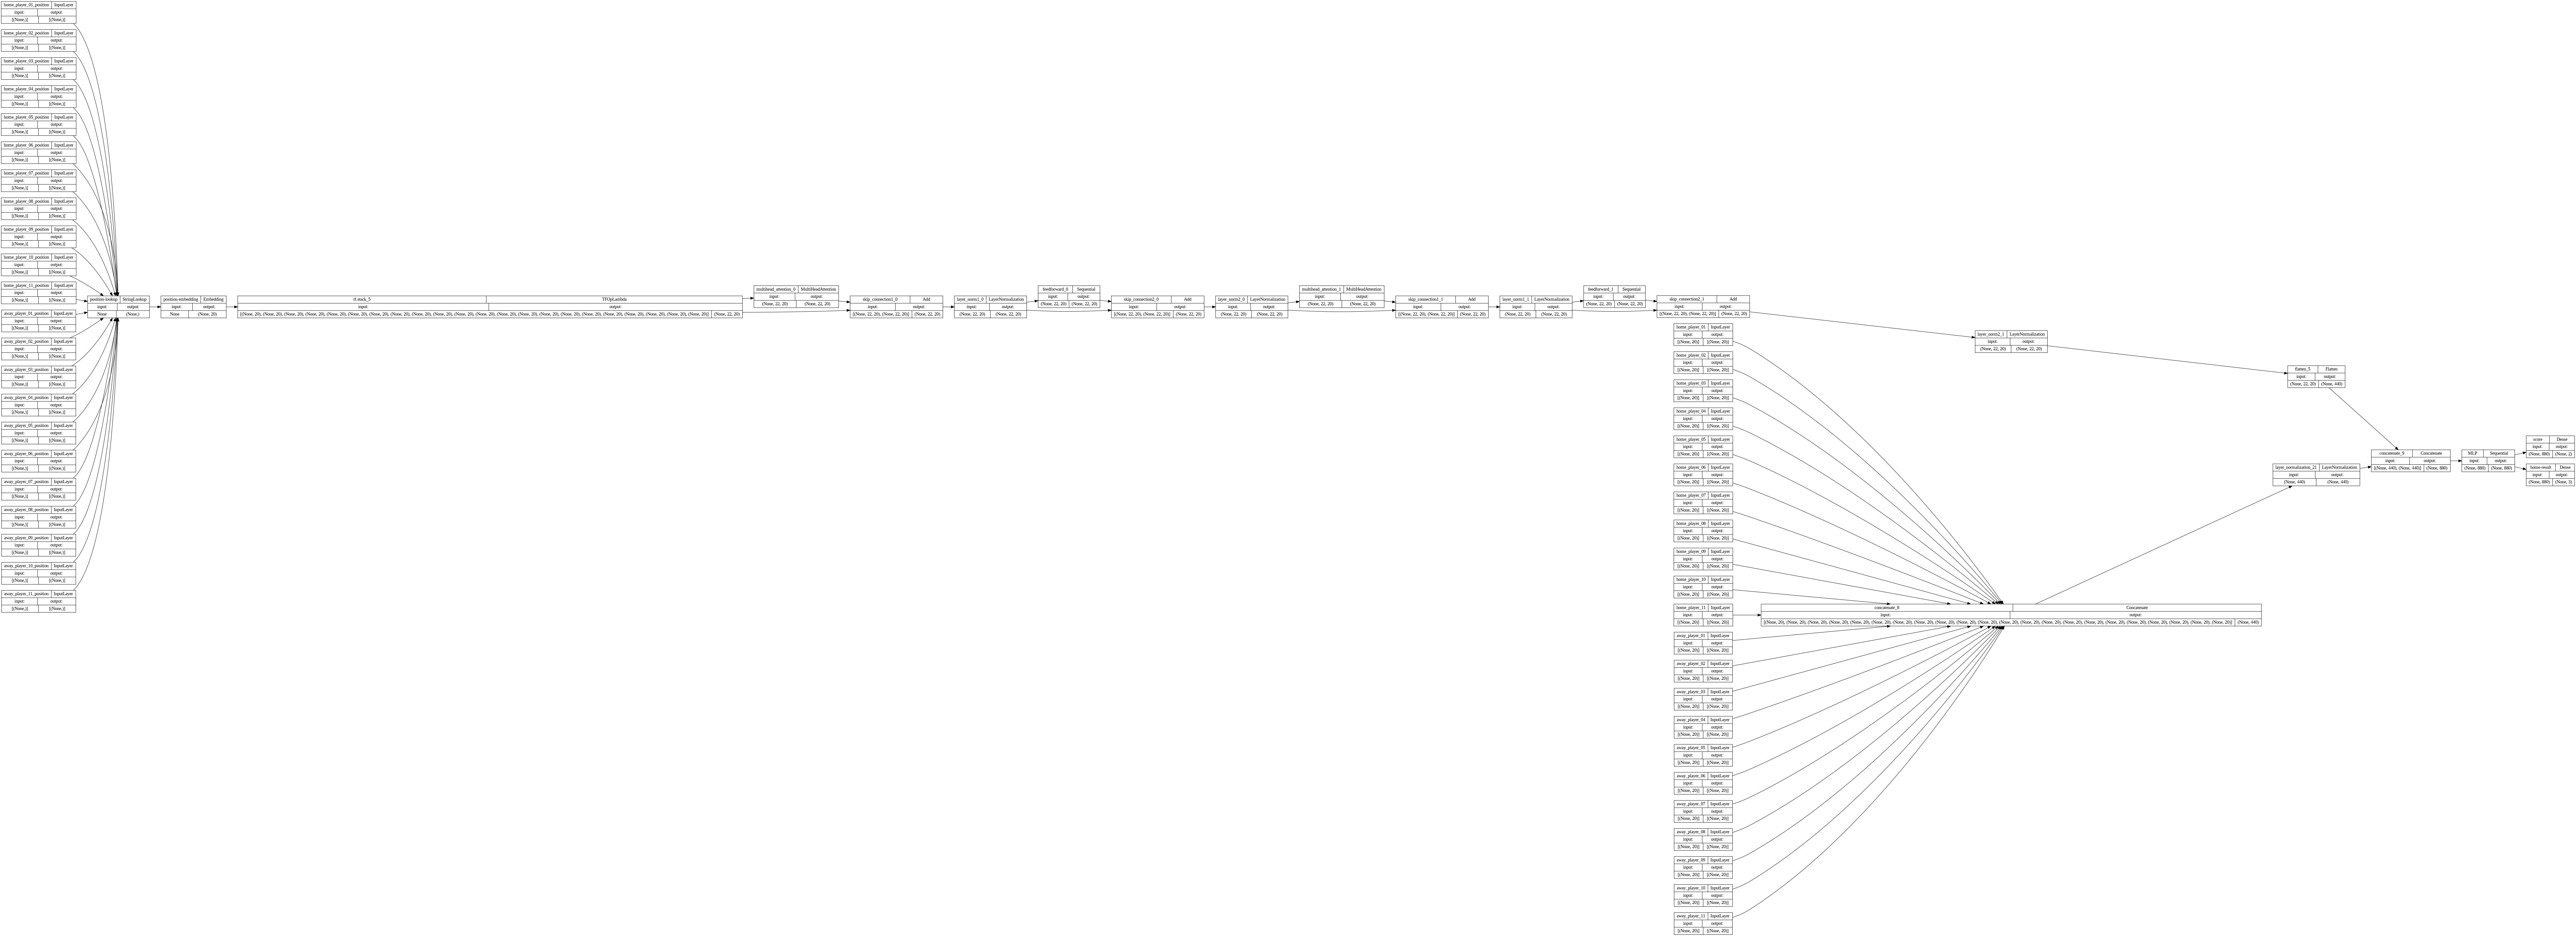

In [ ]:
print("Total model weights:", tabtransformer_model.count_params())
tf.keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")

## Training

In [ ]:
print(X.shape)
print(y.shape)

(362, 462)
(362, 5)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

X_train_home, X_train_away = X_train.loc[:, pd.IndexSlice["Home"]], X_train.loc[:, pd.IndexSlice["Away"]]
X_test_home, X_test_away = X_test.loc[:, pd.IndexSlice["Home"]], X_test.loc[:, pd.IndexSlice["Away"]]
y_train_score, y_train_result = y_train.iloc[:, :2], y_train.iloc[:, 2:]
y_test_score, y_test_result = y_test.iloc[:, :2], y_test.iloc[:, 2:]

In [ ]:
print(X_train_home.shape)
print(X_train_away.shape)
print(X_test_home.shape)
print(X_test_away.shape)
print(y_train_score.shape)
print(y_train_result.shape)
print(y_test_score.shape)
print(y_test_result.shape)

(325, 231)
(325, 231)
(37, 231)
(37, 231)
(325, 2)
(325, 3)
(37, 2)
(37, 3)


### Preprocess Data

In [ ]:
_features = [] + REGISTER_FEATURES
try:
    _features.remove("Pos")
except:
    pass

def get_dataset(df):
    dataset = {
        "home_player_01": [],
        "home_player_01_position": [],
        "home_player_02": [],
        "home_player_02_position": [],
        "home_player_03": [],
        "home_player_03_position": [],
        "home_player_04": [],
        "home_player_04_position": [],
        "home_player_05": [],
        "home_player_05_position": [],
        "home_player_06": [],
        "home_player_06_position": [],
        "home_player_07": [],
        "home_player_07_position": [],
        "home_player_08": [],
        "home_player_08_position": [],
        "home_player_09": [],
        "home_player_09_position": [],
        "home_player_10": [],
        "home_player_10_position": [],
        "home_player_11": [],
        "home_player_11_position": [],
        "away_player_01": [],
        "away_player_01_position": [],
        "away_player_02": [],
        "away_player_02_position": [],
        "away_player_03": [],
        "away_player_03_position": [],
        "away_player_04": [],
        "away_player_04_position": [],
        "away_player_05": [],
        "away_player_05_position": [],
        "away_player_06": [],
        "away_player_06_position": [],
        "away_player_07": [],
        "away_player_07_position": [],
        "away_player_08": [],
        "away_player_08_position": [],
        "away_player_09": [],
        "away_player_09_position": [],
        "away_player_10": [],
        "away_player_10_position": [],
        "away_player_11": [],
        "away_player_11_position": []
    }

    clubs = df.columns.get_level_values(level="Club").unique().to_list()
    players = df.columns.get_level_values(level="Player").unique().to_list()

    # turn the dataset from long-dimensional 1 input to multiple inputs
    for feature in dataset.keys():
        team = feature[:4].capitalize()
        player = feature[5:14].capitalize()
        if "position" in feature:
            # get the position of the player. assume the first position
            dataset[feature] = df.loc[:, pd.IndexSlice[team, player, "Pos"]].apply(lambda x: x.split(",")[0]).to_numpy()
            # dataset[feature] = tf.convert_to_tensor(dataset[feature], dtype=tf.string)
        else:
            dataset[feature] = df.loc[:, pd.IndexSlice[team, player, _features]].to_numpy()
            # dataset[feature] = tf.convert_to_tensor(dataset[feature], dtype=tf.float32)
    return dataset

In [ ]:
X_train = get_dataset(X_train)
X_test = get_dataset(X_test)

In [ ]:
for key, value in X_train.items():
    print(key, value.shape, type(value))

home_player_01 (325, 20) <class 'numpy.ndarray'>
home_player_01_position (325,) <class 'numpy.ndarray'>
home_player_02 (325, 20) <class 'numpy.ndarray'>
home_player_02_position (325,) <class 'numpy.ndarray'>
home_player_03 (325, 20) <class 'numpy.ndarray'>
home_player_03_position (325,) <class 'numpy.ndarray'>
home_player_04 (325, 20) <class 'numpy.ndarray'>
home_player_04_position (325,) <class 'numpy.ndarray'>
home_player_05 (325, 20) <class 'numpy.ndarray'>
home_player_05_position (325,) <class 'numpy.ndarray'>
home_player_06 (325, 20) <class 'numpy.ndarray'>
home_player_06_position (325,) <class 'numpy.ndarray'>
home_player_07 (325, 20) <class 'numpy.ndarray'>
home_player_07_position (325,) <class 'numpy.ndarray'>
home_player_08 (325, 20) <class 'numpy.ndarray'>
home_player_08_position (325,) <class 'numpy.ndarray'>
home_player_09 (325, 20) <class 'numpy.ndarray'>
home_player_09_position (325,) <class 'numpy.ndarray'>
home_player_10 (325, 20) <class 'numpy.ndarray'>
home_player_10_

In [ ]:
# model = create_baseline_model(embedding_dims=len(_features), num_mlp_blocks=2)
model = tabtransformer_model = create_tabtransformer_model(
    embedding_dims = len(REGISTER_FEATURES),
    num_transformer_blocks = NUM_TRANSFORMER_BLOCKS,
    num_heads = NUM_HEADS,
    dropout_rate = DROPOUT_RATE,
    mlp_hidden_units_factors = MLP_HIDDEN_UNITS_FACTORS
)

losses = {
	"score": "mean_absolute_error",
	"home-result": "categorical_crossentropy",
}

metrics = {
	"home-result": "accuracy",
}

model.compile(
    optimizer="Adam",
    loss=losses,
    metrics=metrics,
)

/usr/local/lib/python3.9/dist-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [ ]:
model.summary()

Model: "Football_Prediction_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 home_player_01_position (Input  [(None,)]           0           []                               
 Layer)                                                                                           
                                                                                                  
 home_player_02_position (Input  [(None,)]           0           []                               
 Layer)                                                                                           
                                                                                                  
 home_player_03_position (Input  [(None,)]           0           []                               
 Layer)                                                                   

In [ ]:
history = model.fit(
    [X_train],
    y=[y_train_score, y_train_result],
    batch_size = BATCH_SIZE,
    epochs = NUM_EPOCHS,
    validation_data = [[X_test], [y_test_score, y_test_result]]
)

Epoch 1/50
82/82 [==============================] - 13s 46ms/step - loss: 7.6598 - score_loss: 1.7002 - home-result_loss: 5.9596 - home-result_accuracy: 0.3538 - val_loss: 3.8703 - val_score_loss: 1.2366 - val_home-result_loss: 2.6337 - val_home-result_accuracy: 0.3514
Epoch 2/50
82/82 [==============================] - 3s 33ms/step - loss: 5.2383 - score_loss: 1.5062 - home-result_loss: 3.7320 - home-result_accuracy: 0.4031 - val_loss: 3.6526 - val_score_loss: 1.2773 - val_home-result_loss: 2.3752 - val_home-result_accuracy: 0.5676
Epoch 3/50
82/82 [==============================] - 3s 32ms/step - loss: 3.8817 - score_loss: 1.3047 - home-result_loss: 2.5770 - home-result_accuracy: 0.4431 - val_loss: 3.0671 - val_score_loss: 1.3513 - val_home-result_loss: 1.7158 - val_home-result_accuracy: 0.3784
Epoch 4/50
82/82 [==============================] - 4s 46ms/step - loss: 3.1881 - score_loss: 1.4171 - home-result_loss: 1.7711 - home-result_accuracy: 0.4831 - val_loss: 3.3685 - val_score_lo

In [ ]:
model.save(MODEL_DIR + "tabtransformer-model.h5")

## Inference

In [ ]:
load_model = tf.keras.models.load_model(MODEL_DIR + "baseline-model.h5")

/usr/local/lib/python3.9/dist-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [ ]:
losses = {
	"score": "mean_absolute_error",
	"home-result": "categorical_crossentropy",
}

metrics = {
	"home-result": "accuracy",
}

load_model.compile(
    optimizer="Adam",
    loss=losses,
    metrics=metrics,
)

In [ ]:
# preds = model.predict([X.loc[:, pd.IndexSlice["Home"]], X.loc[:, pd.IndexSlice["Away"]]])

1/1 [==============================] - 0s 412ms/step


In [ ]:
# def result(x):
#     wdl = np.argmax(x)
#     if wdl == 0:
#         return [1, 0, 0]
#     elif wdl == 1:
#         return [0, 1, 0]
#     else:
#         return [0, 0, 1]

# for idx, (score, res) in enumerate(zip(preds[0], preds[1])):
#     print(score, '---', res, '---', pd.Series([res]).apply(lambda x: result(x)).tolist())
#     # if idx == 20:
#     #     break

[0. 0.] --- [1.7527728e-01 8.2471198e-01 1.0626663e-05] --- [[0, 1, 0]]
[0. 0.] --- [5.4577604e-04 7.6200294e-01 2.3745127e-01] --- [[0, 1, 0]]
[0. 0.] --- [9.9952109e-09 8.0825774e-10 9.9999994e-01] --- [[0, 0, 1]]
[0. 0.] --- [2.702758e-04 9.997213e-01 8.496398e-06] --- [[0, 1, 0]]
[0. 0.] --- [2.0405767e-03 9.9786794e-01 9.1586706e-05] --- [[0, 1, 0]]
[0. 0.] --- [3.2619754e-11 9.9999994e-01 4.4837967e-13] --- [[0, 1, 0]]
[0. 0.] --- [9.9999994e-01 4.9069016e-19 8.5171360e-19] --- [[1, 0, 0]]
[0. 0.] --- [1.4519225e-03 9.9854809e-01 3.6301863e-08] --- [[0, 1, 0]]
[0. 0.] --- [1.0000000e+00 2.4684048e-15 7.9667015e-17] --- [[1, 0, 0]]


### Inference

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Projects/Football Team Simulation/data"
SAVE_DIR = DATA_DIR + "/raw/Premier-League/2022-2023_Matches"
TABLE_REF_PATH = DATA_DIR + "/raw/Premier-League/table_ref.csv"
TRANSFORM_DIR = DATA_DIR + "/transformed"
LOOKUP_DIR = DATA_DIR + "/raw/Premier-League/2022-2023_Player_References"
MODEL_DIR = "/content/drive/MyDrive/Projects/Football Team Simulation/models"

In [ ]:
test_register_features = [
    # pre-match player information/stats
    'keeper - Performance - Save%',
    'keeper - Performance - CS%',
    'keeper_adv - Expected - PSxG/SoT',
    'keeper_adv - Expected - /90',
    'shooting - Standard - SoT%',
    'shooting - Standard - SoT/90',
    'shooting - Standard - G/SoT',
    'shooting - Expected - G-xG',
    'passing - xAG',
    'passing - xA',
    'passing - KP',
    'gca - SCA - SCA90',
    'gca - GCA - GCA90',
    'defense - Tkl+Int',
    'defense - Clr',
    'defense - Blocks - Blocks',
    'playing_time - Team Success - PPM',
    'playing_time - Team Success (xG) - On-Off',
    'misc - Performance - Recov',
    'misc - Aerial Duels - Won%',
    # post-match player information/stats
    # "Pos",
]

In [ ]:
player_ref = pd.read_csv(TRANSFORM_DIR + "/player_references.csv", index_col=0)

In [ ]:
request = {
    "home_player_01": "Alisson",
    "home_player_01_position": "GK",
    "home_player_02": "Trent Alexander-Arnold",
    "home_player_02_position": "RB",
    "home_player_03": "Virgil van Dijk",
    "home_player_03_position": "CB",
    "home_player_04": "Joe Gomez",
    "home_player_04_position": "CB",
    "home_player_05": "Andrew Robertson",
    "home_player_05_position": "LB",
    "home_player_06": "Fabinho",
    "home_player_06_position": "DM",
    "home_player_07": "Jordan Henderson",
    "home_player_07_position": "CM",
    "home_player_08": "Harvey Elliott",
    "home_player_08_position": "CM",
    "home_player_09": "Mohamed Salah",
    "home_player_09_position": "RW",
    "home_player_10": "Darwin Núñez",
    "home_player_10_position": "FW",
    "home_player_11": "Cody Gakpo",
    "home_player_11_position": "LW",
    "away_player_01": "Aaron Cresswell",
    "away_player_01_position": "CB",
    "away_player_02": "Abdoulaye Doucouré",
    "away_player_02_position": "RB",
    "away_player_03": "Armstrong Okoflex",
    "away_player_03_position": "DM",
    "away_player_04": "Moussa Niakhate",
    "away_player_04_position": "CB",
    "away_player_05": "Aaron Wan-Bissaka",
    "away_player_05_position": "FB",
    "away_player_06": "Adrián",
    "away_player_06_position": "GK",
    "away_player_07": "Alex Iwobi",
    "away_player_07_position": "AM",
    "away_player_08": "Ben Chilwell",
    "away_player_08_position": "LM",
    "away_player_09": "Bobby Reid",
    "away_player_09_position": "FW",
    "away_player_10": "Emerson Palmieri",
    "away_player_10_position": "FW",
    "away_player_11": "Gonçalo Guedes",
    "away_player_11_position": "RM"
}

In [ ]:
request_data = {
    "home_player_01": [],
    "home_player_01_position": [],
    "home_player_02": [],
    "home_player_02_position": [],
    "home_player_03": [],
    "home_player_03_position": [],
    "home_player_04": [],
    "home_player_04_position": [],
    "home_player_05": [],
    "home_player_05_position": [],
    "home_player_06": [],
    "home_player_06_position": [],
    "home_player_07": [],
    "home_player_07_position": [],
    "home_player_08": [],
    "home_player_08_position": [],
    "home_player_09": [],
    "home_player_09_position": [],
    "home_player_10": [],
    "home_player_10_position": [],
    "home_player_11": [],
    "home_player_11_position": [],
    "away_player_01": [],
    "away_player_01_position": [],
    "away_player_02": [],
    "away_player_02_position": [],
    "away_player_03": [],
    "away_player_03_position": [],
    "away_player_04": [],
    "away_player_04_position": [],
    "away_player_05": [],
    "away_player_05_position": [],
    "away_player_06": [],
    "away_player_06_position": [],
    "away_player_07": [],
    "away_player_07_position": [],
    "away_player_08": [],
    "away_player_08_position": [],
    "away_player_09": [],
    "away_player_09_position": [],
    "away_player_10": [],
    "away_player_10_position": [],
    "away_player_11": [],
    "away_player_11_position": []
}

for key, value in request.items():
    if "position" in key:
        request_data[key] = np.array([value], dtype="object")
    else:
        request_data[key] = player_ref.query("player == @value")[test_register_features].fillna(0).to_numpy()

In [ ]:
for key, value in request_data.items():
    print(key, np.array(value).shape, type(value),)

# request_data

home_player_01 (1, 20) <class 'numpy.ndarray'>
home_player_01_position (1,) <class 'numpy.ndarray'>
home_player_02 (1, 20) <class 'numpy.ndarray'>
home_player_02_position (1,) <class 'numpy.ndarray'>
home_player_03 (1, 20) <class 'numpy.ndarray'>
home_player_03_position (1,) <class 'numpy.ndarray'>
home_player_04 (1, 20) <class 'numpy.ndarray'>
home_player_04_position (1,) <class 'numpy.ndarray'>
home_player_05 (1, 20) <class 'numpy.ndarray'>
home_player_05_position (1,) <class 'numpy.ndarray'>
home_player_06 (1, 20) <class 'numpy.ndarray'>
home_player_06_position (1,) <class 'numpy.ndarray'>
home_player_07 (1, 20) <class 'numpy.ndarray'>
home_player_07_position (1,) <class 'numpy.ndarray'>
home_player_08 (1, 20) <class 'numpy.ndarray'>
home_player_08_position (1,) <class 'numpy.ndarray'>
home_player_09 (1, 20) <class 'numpy.ndarray'>
home_player_09_position (1,) <class 'numpy.ndarray'>
home_player_10 (1, 20) <class 'numpy.ndarray'>
home_player_10_position (1,) <class 'numpy.ndarray'>


In [ ]:
# _temp = [values for key, values in request_data.items()]
# preds = load_model.predict(_temp)
preds = load_model.predict([request_data])

1/1 [==============================] - 0s 67ms/step


In [ ]:
home_score = preds[0][0][0]
away_score = preds[0][0][1]
home_result = np.argmax(preds[1][0])
home_result_dict = {0: "W", 1: "D", 2:"L"}
home_result = home_result_dict[home_result]

In [ ]:
print(home_score, away_score, home_result)

1.9505494 1.2561492 D


### Example Succeed Predict

In [ ]:
'''
POST /api/predict/
'''

'''
HTTP 200 OK
Allow: POST, OPTIONS
Content-Type: application/json
Vary: Accept
'''

{
    "id": 4,
    "datetime": "2023-04-09T20:41:37.037487Z",
    "home_player_01": "Alisson",
    "home_player_01_position": "GK",
    "home_player_02": "Trent Alexander-Arnold",
    "home_player_02_position": "RB",
    "home_player_03": "Andrew Robertson",
    "home_player_03_position": "LB",
    "home_player_04": "Virgil van Dijk",
    "home_player_04_position": "CB",
    "home_player_05": "Ibrahima Konaté",
    "home_player_05_position": "CB",
    "home_player_06": "Fabinho",
    "home_player_06_position": "DM",
    "home_player_07": "Thiago Alcántara",
    "home_player_07_position": "CM",
    "home_player_08": "Jordan Henderson",
    "home_player_08_position": "CM",
    "home_player_09": "Darwin Núñez",
    "home_player_09_position": "LW",
    "home_player_10": "Mohamed Salah",
    "home_player_10_position": "RW",
    "home_player_11": "Cody Gakpo",
    "home_player_11_position": "FW",
    "away_player_01": "Aaron Ramsdale",
    "away_player_01_position": "GK",
    "away_player_02": "Ben White",
    "away_player_02_position": "RB",
    "away_player_03": "Oleksandr Zinchenko",
    "away_player_03_position": "LB",
    "away_player_04": "Rob Holding",
    "away_player_04_position": "CB",
    "away_player_05": "Gabriel Dos Santos",
    "away_player_05_position": "CB",
    "away_player_06": "Thomas Partey",
    "away_player_06_position": "DM",
    "away_player_07": "Granit Xhaka",
    "away_player_07_position": "CM",
    "away_player_08": "Martin Ødegaard",
    "away_player_08_position": "CM",
    "away_player_09": "Martinelli",
    "away_player_09_position": "LW",
    "away_player_10": "Bukayo Saka",
    "away_player_10_position": "RW",
    "away_player_11": "Gabriel Jesus",
    "away_player_11_position": "FW",
    "home_score_pred": 1.9134858846664429,
    "away_score_pred": 0.9105390310287476,
    "home_result_pred": "W"
}